In [1]:
def Random_Walker(ne, ns):     
    x = np.zeros((ne, ns))
    y = np.zeros((ne, ns))
    theta = np.zeros((ne, ns))   

    delta_x = 0.1
    delta_y = 0.1
    delta_theta = np.pi / 40

    eta = 0.001
    a = 5.9
    b = 1.3
    s = 2. / (np.sqrt(a ** 2 - b ** 2)) * np.log((a + np.sqrt(a ** 2 - b ** 2)) / b)
    gama_par = 16 * np.pi * eta * (a ** 2 - b ** 2) / ((2 * a ** 2 - b ** 2) * s - (2 * a))
    gama_per = 32 * np.pi * eta * (a ** 2 - b ** 2) / ((2 * a ** 2 - 3 * b ** 2) * s + (2 * a))
    gama_rotational_per = 32 * np.pi * eta * ((a ** 2 - b ** 2) * b ** 2) / (3 * (2 * a ** 2 - (b ** 2) * s))
    KT = 1.38 * (19 + 273)

    D = np.array([[KT / gama_par, 0], [0, KT / gama_per]])

    D_theta = 1 / gama_rotational_per
    D_par = (KT / gama_par) * (10 ** (-5))
    D_per = (KT / gama_per) * (10 ** (-5))

    for e in range(ne):
        for i in range(ns - 1):
            r1 = np.random.rand()
            theta[e, i + 1] = theta[e, i] + delta_theta * np.sign(r1 - 0.5)

            r2 = np.random.rand()
            p_x = D_par / (D_par + D_per)

            if r2 < p_x:
                y[e, i + 1] = 0

                r3 = np.random.rand()
                x[e, i + 1] = delta_x * np.sign(r3 - 0.5)
            else:
                x[e, i + 1] = 0

                r4 = np.random.rand()
                y[e, i + 1] = delta_y * np.sign(r4 - 0.5)
    return x, y, theta

def calculate_MSDs(ns, x, y, theta, interval, R, time):
    
    x_new = x * np.cos(theta) - y * np.sin(theta)
    x_f = np.cumsum(x_new, axis=1)

    y_new = x * np.sin(theta) + y * np.cos(theta)
    y_f = np.cumsum(y_new, axis=1)

    theta2 = theta ** 2
    MSD_theta = np.mean(theta2, axis=0) - (np.mean(theta, axis=0)) ** 2
    

    x2 = x_f ** 2
    MSD_x = np.mean(x2, axis=0) - (np.mean(x_f, axis=0)) ** 2

    y2 = y_f ** 2
    MSD_y = np.mean(y2, axis=0) - (np.mean(y_f, axis=0)) ** 2
    
    
    D_new_x = np.zeros(ns - interval - 1)
    D_new_y = np.zeros(ns - interval - 1)
    

    for i in range(len(time) - interval - 1):
        start = i
        stop = i + interval
        p_1 = np.polyfit(time[start:stop], MSD_x[start:stop], 1)
        D_new_x[i] = p_1[0] / 2
        p_2 = np.polyfit(time[start:stop], MSD_y[start:stop], 1)
        D_new_y[i] = p_2[0] / 2

    

    return MSD_x, MSD_y, MSD_theta, D_new_x, D_new_y
    

def Plot_MSDs(R, D_x_All, D_y_All,MSD_x_All, MSD_y_All,MSD_theta_All, time, interval):
    # Calculate and plot D
    D_x_Final = np.mean(D_x_All, axis=0)
    len(D_x_Final)
    D_x_Error = np.std(D_x_All, axis=0) / np.sqrt(R)
    D_y_Final = np.mean(D_y_All, axis=0)
    D_y_Error = np.std(D_y_All, axis=0) / np.sqrt(R)

    xaxis = np.arange(1, len(time) - interval)
    
    plt.figure()
    plt.errorbar(xaxis, D_x_Final, D_x_Error, color=[0.73, 0.83, 0.96], label='D_x')
    plt.plot(xaxis, D_x_Final, 'b')
    plt.errorbar(xaxis, D_y_Final, D_y_Error, color=[1, 0.6, 0.78], label='D_y')
    plt.plot(xaxis, D_y_Final, 'r')
    plt.xscale('log')
    plt.xlabel('Time[s]')
    plt.ylabel('D_(x,y) [\u03BCm^2/s]')
    plt.legend()
    
    # Save D plot
    #plt.savefig('D.png')
    
    # Calculate and plot MSD x, y, theta
    MSD_x_Final = np.mean(MSD_x_All, axis=0)
    MSD_x_Error = np.std(MSD_x_All, axis=0) / np.sqrt(R)
    MSD_y_Final = np.mean(MSD_y_All, axis=0)
    MSD_y_Error = np.std(MSD_y_All, axis=0) / np.sqrt(R)
    MSD_theta_Final = np.mean(MSD_theta_All, axis=0)
    MSD_theta_Error = np.std(MSD_theta_All, axis=0) / np.sqrt(R)

    xaxis = time

    plt.figure()
    plt.errorbar(xaxis, MSD_x_Final, MSD_x_Error, color=[0.73, 0.83, 0.96], label='MSD_x')
    plt.plot(xaxis, MSD_x_Final, 'b')
    plt.errorbar(xaxis, MSD_y_Final, MSD_y_Error, color=[1, 0.6, 0.78], label='MSD_y')
    plt.plot(xaxis, MSD_y_Final, 'r')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Time[s]')
    plt.ylabel('MSD_(x,y)[\u03BCm^2]')
    plt.legend()
    
    # Save MSD plot
    #plt.savefig('MSD.png')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def main():
    ns = 400  # Number of Steps
    ne = 1000  # Number of Ensembles
    interval = 50
    
    R = 200
    D_x_All = np.zeros((R, ns - interval - 1))
    D_y_All = np.zeros((R, ns - interval - 1))
    MSD_x_All = np.zeros((R, ns))
    MSD_y_All = np.zeros((R, ns))
    MSD_theta_All = np.zeros((R, ns))
    
    delta_t = 0.04
    time = np.arange(0, ns * delta_t, delta_t)
    
    for Repeat in tqdm(range(1, R + 1), desc="Simulating"):
    #for Repeat in range(1, R + 1):
        x, y, theta = Random_Walker(ne, ns)
        
        MSD_x, MSD_y, MSD_theta, D_new_x, D_new_y =calculate_MSDs(ns, x, y, theta, interval, R, time)
        
        MSD_x_All[Repeat - 1, :] = MSD_x
        MSD_y_All[Repeat - 1, :] = MSD_y
        MSD_theta_All[Repeat - 1, :] = MSD_theta

        D_x_All[Repeat - 1, :] = D_new_x
        D_y_All[Repeat - 1, :] = D_new_y
        
    Plot_MSDs(R, D_x_All, D_y_All,MSD_x_All, MSD_y_All,MSD_theta_All, time, interval)

Simulating: 100%|████████████████████████████████████████████████████████████████████| 200/200 [08:22<00:00,  2.51s/it]


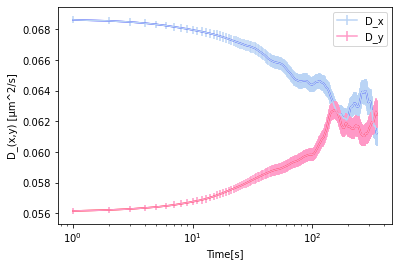

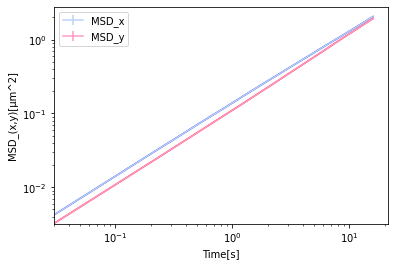

In [3]:
if __name__ == "__main__":
    main()